In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

# Example

In [30]:
w = 256
h = 256
mask1 = np.random.sample((w, h))
mask2 = np.where(mask1 > 0.5, 1., 0)
mask = mask * mask2

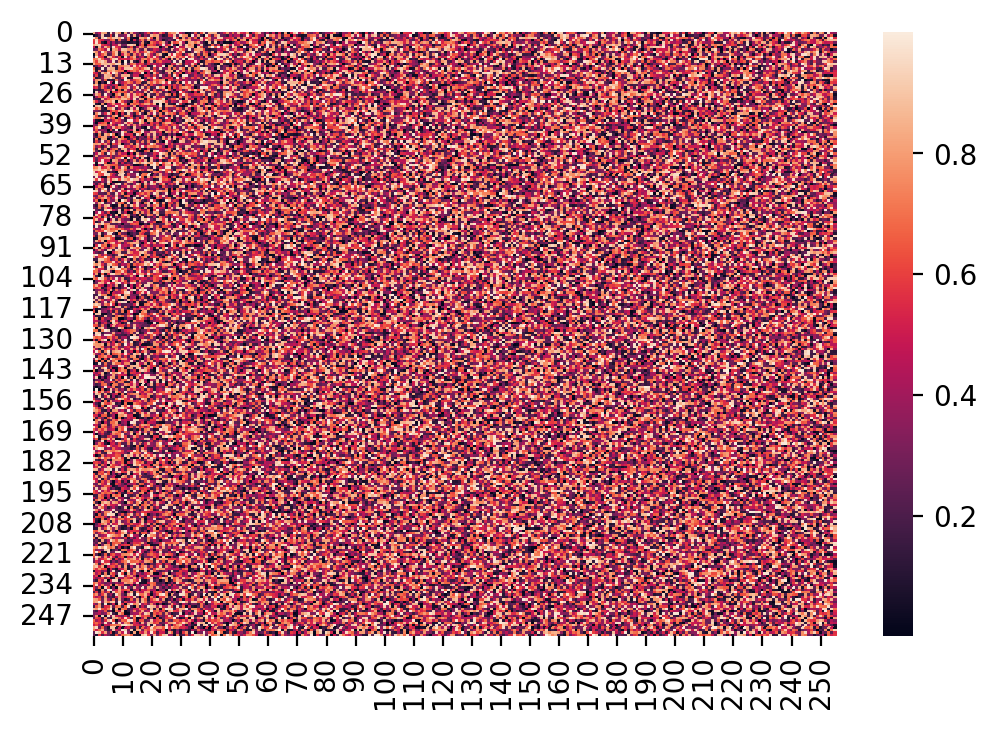

In [32]:
plt.figure(dpi=200)
ax = sns.heatmap(mask1)
plt.show()

In [24]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

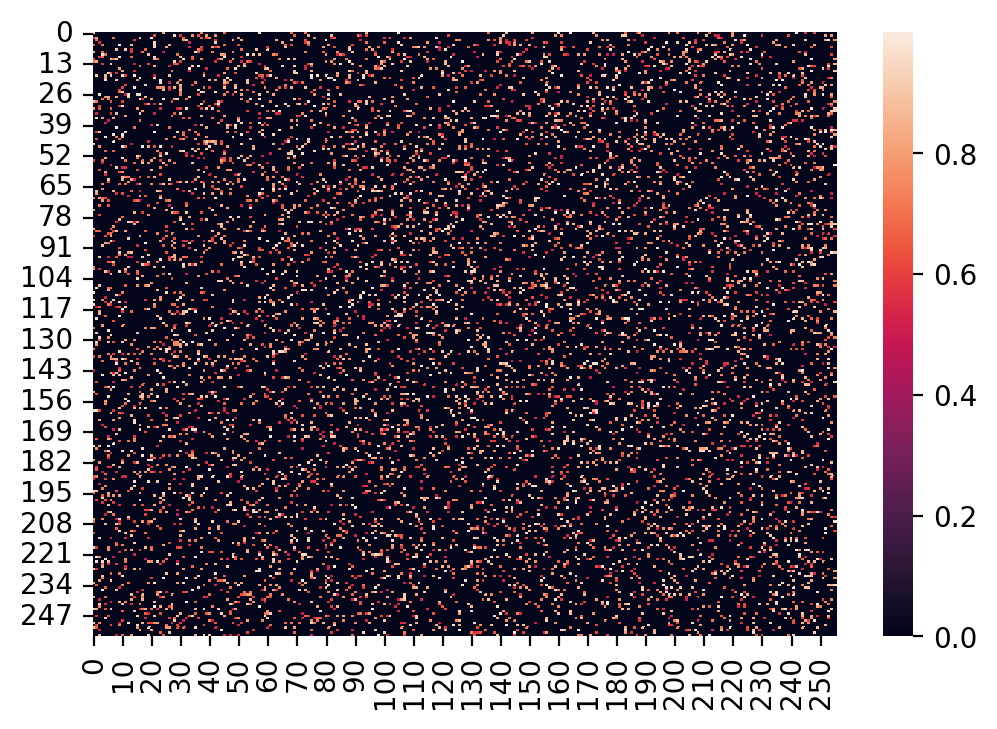

In [31]:
plt.figure(dpi=200)
ax = sns.heatmap(mask)
plt.show()

# Extract KP and mask

In [33]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
import pytorch_lightning as pl
import os
from pytorch_lightning.utilities.parsing import AttributeDict
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import albumentations
import torchvision.transforms as transforms
import torchvision

In [34]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [35]:
from sparse_feature_pyramid.model import SparseFeaturePyramidAutoencoder
from sparse_feature_pyramid.data import SevenScenesDataModule
from sparse_feature_pyramid.utils import UniversalFactory
from sparse_feature_pyramid.utils.clearml_figure_reporter import ClearmlFigureReporter

factory = UniversalFactory([SparseFeaturePyramidAutoencoder])

In [36]:
model_parameters = AttributeDict(
    name="SparseFeaturePyramidAutoencoder",
    optimizer=AttributeDict(),
    feature_dimensions=[8, 16, 32, 64, 128],
    size_loss_koef=1 / 500000.,
    input_dimension=3,
    kl_loss_coefficient=0.5
)

model = factory.make_from_parameters(model_parameters)
model.set_figure_reporter(ClearmlFigureReporter())

In [45]:
# Тренируем на всех сценах
image_size = 256
data_module_parameters = {
    "batch_size": 16,
    "num_workers": 4,
    "image_size": image_size,
    "scenes": ["fire"], #, "chess", "pumpkin", "stairs", "heads", "office", "redkitchen"],
    "center_crop": True,
    "random_jitter": True,
    "random_rotation": True,
    "root_dataset_path": "/home/andrei/media/7scenes"
}
# task.connect(data_module_parameters)
scene = data_module_parameters["scenes"][0]
data_module = SevenScenesDataModule(**data_module_parameters)

[ToyDataModule] - train subset size 2000
[ToyDataModule] - validation dataset size 2000


In [46]:
%matplotlib inline
batch = None
for x in data_module.test_dataloader():
    batch = x
    break

In [38]:
checkpoint = torch.load("/home/andrei/git/sparse-feature-pyramid/notebook/version_14/checkpoints/epoch=89-step=36629.ckpt")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [47]:
def get_image(batch, index):
    input_image = batch["image"][index].detach().cpu().numpy().transpose(1, 2, 0)
    input_image = input_image * np.array(data_module._std)[None, None] + np.array(data_module._mean)[None, None]
    input_image = np.clip(input_image, 0, 1)
    return input_image

In [48]:
from PIL import Image

In [93]:
model_mean_std = False

In [94]:
model.eval()
convert_tensor = transforms.ToTensor()
newsize = (256, 256)

orig_image = Image.open('/home/andrei/git/d2-net/hpatches_sequences/hpatches-sequences-release/i_ajuntament/1.ppm')

# reshape image
w, h = orig_image.size
image_to_normalized = np.array(orig_image.resize(newsize)) / 256

# cinvert to proper shape for NN
if model_mean_std:
    mean = data_module._mean
    std = data_module._std
else:
    mean = [image_to_normalized[:, :, channel].mean() for channel in range(image_to_normalized.shape[2])]
    std = [image_to_normalized[:, :, channel].std() for channel in range(image_to_normalized.shape[2])]

image_to_model = (image_to_normalized - np.array(mean))/np.array(std)
image_batch = convert_tensor(image_to_model.astype('float32'))[None]
output = model(image_batch)


output = model(batch["image"])

In [102]:
outpu

5

In [107]:
level = 2
mask = output[2][level][0][0].detach().cpu().numpy()#.reshape(-1)

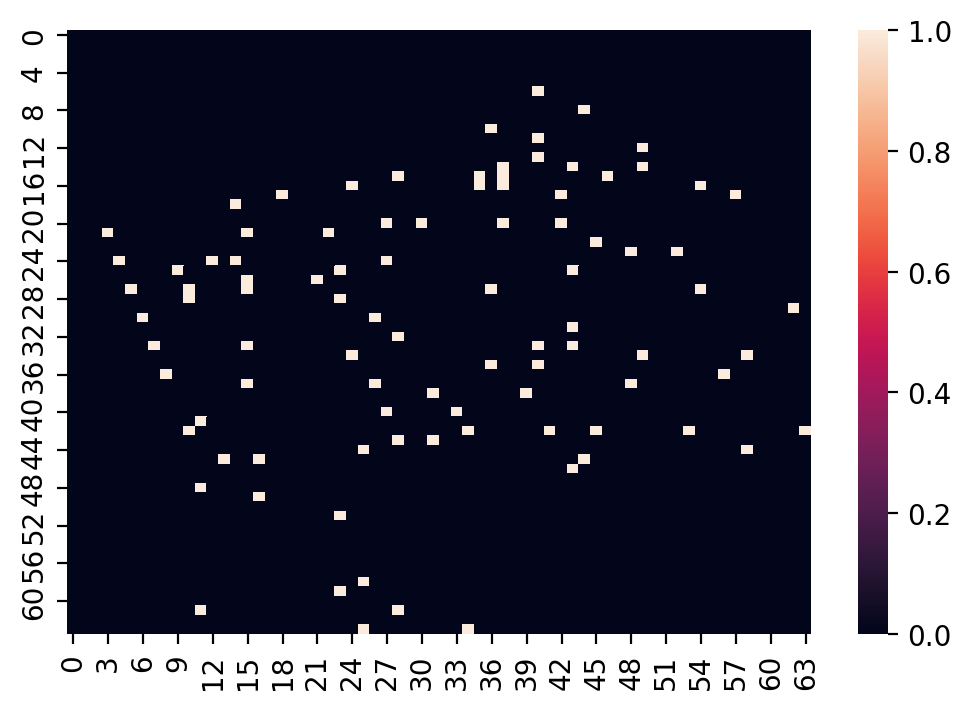

In [110]:
plt.figure(dpi=200)
ax = sns.heatmap(mask)
plt.show()